In [1]:
import torch
from easy_transformer import EasyTransformer

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(f"Using {device} device")
torch.set_grad_enabled(False)

model = EasyTransformer.from_pretrained('gpt2').to(device)

# Convenience function for decoding token
decode = model.tokenizer.decode

# Convenience function for encoding token
def encode(t):
    global model
    result = model.tokenizer.encode(t)
    if len(result) != 1:
        raise Exception(f"Not a single token: {t}")
    return result[0]

unembed = model.unembed.W_U.data
embed = model.embed.W_E.data
d_M = model.cfg.d_model
d_V = model.cfg.d_vocab

print(unembed.shape, embed.shape, d_M, d_V)

Using cpu device
Loading model: gpt2


/home/giles/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
Using pad_token, but it is not set yet.


Moving model to device:  cpu
Finished loading pretrained model gpt2 into EasyTransformer!
Moving model to device:  cpu
torch.Size([768, 50257]) torch.Size([50257, 768]) 768 50257


In [2]:
unembed_norm = torch.nn.functional.normalize(unembed, dim=0)

In [3]:
#embed2 = torch.linalg.pinv(embed).T
num = 20
m0 = embed[encode(' war'),:]
v0 = torch.matmul(m0, unembed)
values = [(v.item(),t) for t,v in enumerate(v0)]
values.sort(reverse=True)
top_tokens = torch.tensor([t for v,t in values[:num]])
top_values = torch.tensor([v for v,t in values[:num]])
positions = unembed_norm[:,top_tokens]
for i in range(num):
    dist = torch.linalg.vector_norm(positions[:,0] - positions[:,i]).item()
    print(f'{decode(top_tokens[i]):20}', f'{top_values[i].item():20}', f'{dist:20}')

 war                    9.317658424377441                  0.0
 wars                   7.340035438537598   0.8603461384773254
 warr                   6.827051162719727    1.268459439277649
 War                    6.460123062133789   0.8579806089401245
 conflic               6.3647050857543945   1.3311243057250977
war                     6.172027587890625   1.0479792356491089
War                     5.925832271575928    1.107279896736145
 warfare                5.797113418579102   1.0053783655166626
 destro                 5.156200885772705    1.410672664642334
 encount                4.910674095153809   1.4101799726486206
 Wars                   4.803774356842041   1.1327097415924072
 wartime                4.773899555206299    1.086071252822876
 gobl                   4.547875881195068   1.3838707208633423
 Warfare                 4.54132604598999   1.2237789630889893
 weap                   4.528748512268066    1.344349980354309
 challeng               4.512631416320801   1.442833542

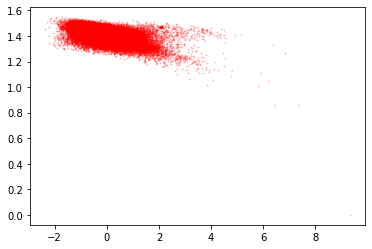

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

t = encode(' war')
m = embed[t,:]
score0 = torch.matmul(m, unembed)

pos_broadcast = unembed_norm[:,t].reshape(d_M,1).expand(d_M, d_V)
score1 = torch.norm(unembed_norm - pos_broadcast, dim=0)

plt.scatter(score0, score1, s=1, color=(1, 0, 0), alpha=0.2)

[' cat', ' cats', ' Cat', 'Cat', 'cat']
21.971466064453125


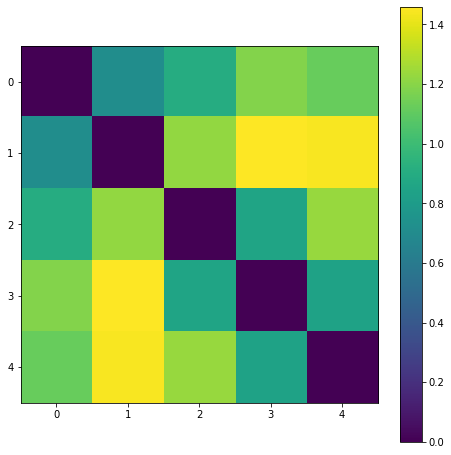

In [7]:
plt.rcParams['figure.figsize'] = [8, 8]

def subtract_tok(v0, tok1):
    t1 = encode(tok1)
    v1 = embed[t1,:]
    #print(v1)
    u0 = torch.matmul(v0, unembed)
    u1 = torch.matmul(v1, unembed)
    mult = u0[t1] / u1[t1]
    return v0 - mult * v1

num = 5
m0 = embed[encode(' cat'),:]
m0 = subtract_tok(m0, ' corrid')
m0 = subtract_tok(m0, ' catcher')
m0 = subtract_tok(m0, ' comet')

v0 = torch.matmul(m0, unembed)
values = [(v.item(),t) for t,v in enumerate(v0)]
values.sort(reverse=True)
top_tokens = torch.tensor([t for v,t in values[:num]])

un_num = unembed_norm[:,top_tokens]
dist = torch.zeros((num, num))
for i in range(num):
    for j in range(num):
        dist[i,j] = torch.linalg.vector_norm(un_num[:,i] - un_num[:,j]) ** 2
score = dist.sum().item()
print([decode(t) for t in top_tokens])

print(score)
plt.imshow(dist)
plt.colorbar()

30.441232681274414
['oreAnd', ' tremend', ' tolerated', 'mble', ' exha']


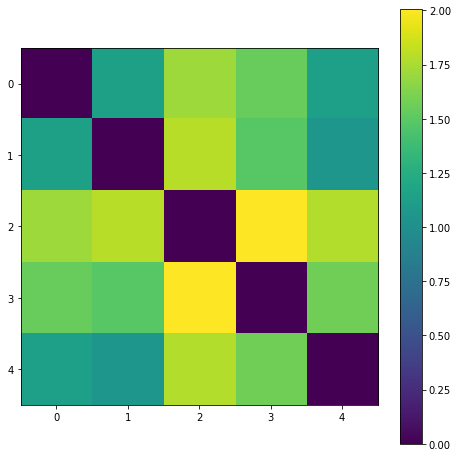

In [8]:
plt.rcParams['figure.figsize'] = [8, 8]

def subtract_tok(v0, tok1):
    t1 = encode(tok1)
    v1 = embed[t1,:]
    #print(v1)
    u0 = torch.matmul(v0, unembed)
    u1 = torch.matmul(v1, unembed)
    mult = u0[t1] / u1[t1]
    return v0 - mult * v1

num = 5
m0 = embed[encode(' cat'),:]
m0 = subtract_tok(m0, ' corrid')
m0 = subtract_tok(m0, ' catcher')
m0 = subtract_tok(m0, ' comet')


generator = torch.Generator()
generator.manual_seed(12345)

best_score = 100000000
best = None
best_dist = None
best_names = None
for k in range(100):
    m0 = torch.normal(0, 1, (d_M,), generator=generator)
    v0 = torch.matmul(m0, unembed)
    values = [(v.item(),t) for t,v in enumerate(v0)]
    values.sort(reverse=True)
    top_tokens = torch.tensor([t for v,t in values[:num]])

    un_num = unembed_norm[:,top_tokens]
    dist = torch.zeros((num, num))
    for i in range(num):
        for j in range(num):
            dist[i,j] = torch.linalg.vector_norm(un_num[:,i] - un_num[:,j]) ** 2
    score = dist.sum().item()
    if score < best_score:
        best_score = score
        best = m0
        best_dist = dist
        best_names = [decode(t) for t in top_tokens]

print(best_score)
print(best_names)
plt.imshow(best_dist)
plt.colorbar()

In [43]:
import random
#num_samples = 1000000
n_samples = 100000
batch_size = 10000

def do_score_rubbish(title, m, seed=12346):
    v = torch.matmul(10 * torch.nn.functional.normalize(m, dim=0), unembed)
    p = torch.nn.functional.softmax(v, dim=0)

    generator = torch.Generator()
    generator.manual_seed(seed)

    score = 0
    denom = 0
    for i in range(0, num_samples, batch_size):
        ind0 = torch.randint(0, d_V, (batch_size,), generator=generator)
        ind1 = torch.randint(0, d_V, (batch_size,), generator=generator)
        mat0 = unembed_norm[:,ind0]
        mat1 = unembed_norm[:,ind1]
        norms = torch.linalg.vector_norm(mat0 - mat1, dim=0)
        p0 = p[ind0]
        p1 = p[ind1]
        score += (p0 * p1 * norms).sum().item()
        denom += (p0 * p1).sum().item()
    print(f'{title:20}', score/denom)

def do_score_probably_rubbish(title, m, seed=12346):
    v = torch.matmul(10 * torch.nn.functional.normalize(m, dim=0), unembed)
    p = torch.nn.functional.softmax(v, dim=0)
    
    random.seed(seed)
    score = 0
    for i in range(0, n_samples, batch_size):
        #print(i)
        ind0 = torch.tensor(random.choices(range(d_V), weights=p, k=batch_size))
        ind1 = torch.tensor(random.choices(range(d_V), weights=p, k=batch_size))
        mat0 = unembed_norm[:,ind0]
        mat1 = unembed_norm[:,ind1]
        norms = torch.linalg.vector_norm(mat0 - mat1, dim=0)
        score += norms.sum().item()
    print(f'{title:20}', score)

def do_scores(title, m):
    for seed in range(12346, 12350):
        do_score(title, m, seed)
    
#for tok in [' cat', ' dog', ' leaves']:
#    m = embed[encode(tok),:]
#    do_scores(tok, m)

#generator = torch.Generator()
#generator.manual_seed(12345)
#do_scores('(random)', torch.normal(0, 1, (d_M,), generator=generator))

In [73]:
def model_vec_dist(t0, t1):
    v0 = unembed_norm[:,t0]
    v1 = unembed_norm[:,t1]
    #return torch.linalg.vector_norm(v0 - v1).item() ** 2
    return 2 - 2 * torch.dot(v0, v1)    # this works because v0, v1 have norm 1

t0 = encode(' cat')
t1 = encode(' dog')
print(model_vec_dist(t0, t1))

tensor(1.0365)


[' war', ' wars', ' warr', ' War', ' conflic', 'war', 'War', ' warfare', ' destro', ' Wars', ' wartime']
[0.00482127 0.00236285 0.00147909 0.00111387 0.00090036 0.00084799
 0.00076874 0.00067071 0.00064204 0.00046081 0.00026749]
[' savage', 'Magn', 'ian', './', ' Grove', ' Others', ' faction', 'omsky', 'ewitness', ' Atlantic', 'orc']
[0.00172164 0.00169085 0.00149245 0.00141344 0.00132417 0.00127404
 0.00122344 0.00115233 0.00109883 0.00100574 0.00094254]


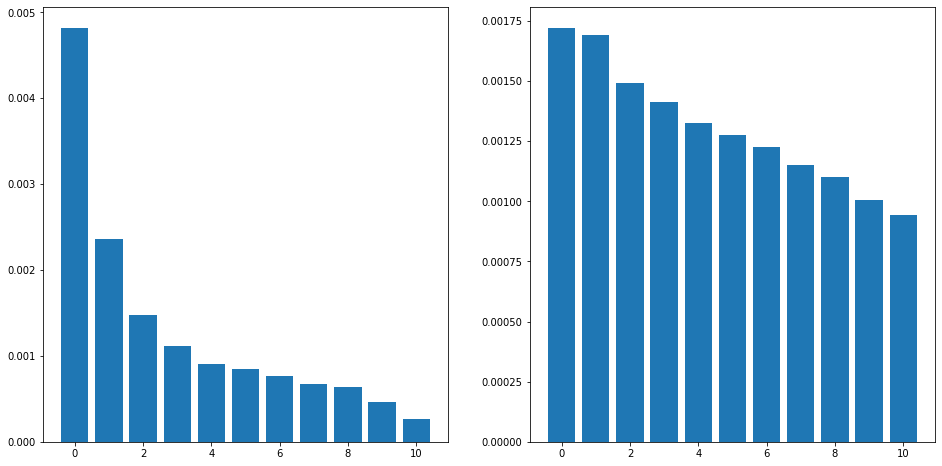

In [89]:
from sklearn.decomposition import PCA

def print_toks_pca(toks, ax):
    print(toks)
    ntok = len(toks)
    ts = torch.tensor([encode(tok) for tok in toks])
    vs = unembed_norm[:,ts]

    pca = PCA(n_components=ntok)
    pca.fit(vs)
    var = pca.explained_variance_
    print(var)
    
    ax.bar(range(ntok), var)

plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots(1,2)
    
toks = [' war', ' wars', ' warr', ' War', ' conflic', 'war', 'War', ' warfare', ' destro', ' Wars', ' wartime']
print_toks_pca(toks, ax[0])

random.seed(12345)
toks = [decode(t) for t in random.sample(range(d_V), k=11)]
print_toks_pca(toks, ax[1])

[(3.1668122346673044e-07, ' cat'), (4.395938333345839e-07, ' dog'), (0.6615617275238037, ' dogs'), (0.7557071447372437, ' cats'), (0.8050432801246643, ' canine'), (0.8112043142318726, ' Dog'), (0.8206338286399841, ' puppy'), (0.8350015878677368, ' Cat'), (0.8534741401672363, ' pet'), (0.8581989407539368, ' animal')]


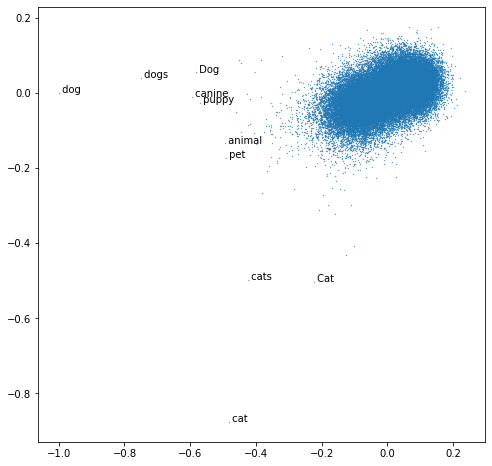

In [175]:
data = torch.zeros((d_M,d_M))
data[0,:] = unembed_norm[:,encode(' dog')]
data[1,:] = unembed_norm[:,encode(' cat')]

#pca = PCA(n_components=2)
#pca.fit(unembed_norm.T)
#data[:2,:] = torch.tensor(pca.components_)

orth = torch.linalg.qr(data.T)[0]

proj = torch.matmul(orth.T, unembed_norm)
plt.rcParams['figure.figsize'] = [8, 8]
xs = proj[0,:]
ys = proj[1,:]
ds = torch.linalg.vector_norm(proj[2:,:], dim=0)

values = [(v.item(),decode(i)) for i,v in enumerate(ds)]
values.sort(reverse=False)
print(values[:10])

plt.scatter(xs, ys, s=0.1)
for i in range(d_V):
    if ds[i] < values[10][0]:
        plt.text(xs[i], ys[i], decode(i), parse_math=False)